In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.spatial.transform import Rotation


In [7]:
def initialize_filter():
    """
    カルマンフィルターを初期化する
    P, Q, R は適切な値を設定する必要がある
    """

    # 初期状態推定値 (クォータニオン)
    # 初期の姿勢は単位クォータニオン（姿勢なし）
    x = np.array([1.0, 0.0, 0.0, 0.0])

    # 初期推定誤差共分散行列
    P = np.eye(4)

    # プロセスノイズの共分散行列
    Q = np.eye(4) * 0.01

    # 観測ノイズの共分散行列
    R = np.eye(3) * 0.1

    return x, P, Q, R


def quaternion_to_rotation_rate(q, gyro_data):
    """
    クォータニオンを角速度に変換する

    Args:
        q (np.array): クォータニオン
        gyro_data (np.array): ジャイロセンサーの値
    """

    # クォータニオンの共役を計算
    q_conj = np.array([q[0], -q[1], -q[2], -q[3]])

    # クォータニオンを回転ベクトルに変換
    omega = 2.0 * Rotation.from_quat(q_conj).inv().as_rotvec() * gyro_data
    return omega


def update_filter(x, P, Q, R, accel_data, gyro_data, dt):
    """
    カルマンフィルターを更新する

    Args:
        x (np.array): 状態推定値
        P (np.array): 推定誤差共分散行列
        Q (np.array): プロセスノイズの共分散行列
        R (np.array): 観測ノイズの共分散行列
        accel_data (np.array): 加速度センサーの値
        gyro_data (np.array): ジャイロセンサーの値
        dt (float): サンプリング時間
    """

    # 予測ステップ
    x_gyro = gyro_data[0]
    y_gyro = gyro_data[1]
    z_gyro = gyro_data[2]

    # 角速度ベクトル
    omega = np.array([
        [0, -x_gyro, -y_gyro, -z_gyro],
        [x_gyro,       0,  z_gyro, -y_gyro],
        [y_gyro, -z_gyro,       0,  x_gyro],
        [z_gyro,  y_gyro, -x_gyro,       0]
    ])

    # np.eye(4) は 4x4 の単位行列を生成する
    # 0.5 はサンプリング時間の半分
    # dt はサンプリング時間
    A = np.eye(4) + (0.5 * dt * omega)
    del omega

    x_pred = A.dot(x)
    P_pred = A.dot(P).dot(A.T) + Q

    # カルマンゲインの計算
    # 3x4のゼロ行列を作成
    H = np.zeros((3, 4))

    # H行列の適切な要素に値を設定
    H[0, 1] = 1  # x方向の加速度とx軸回りの姿勢の関係
    H[1, 2] = 1  # y方向の加速度とy軸回りの姿勢の関係
    H[2, 3] = 1  # z方向の加速度とz軸回りの姿勢の関係

    K = P_pred.dot(H.T).dot(np.linalg.inv(H.dot(P_pred).dot(H.T) + R))

    # 角速度をクォータニオンに変換
    omega = quaternion_to_rotation_rate(x, gyro_data)

    # 観測更新
    x_updated = x_pred + K.dot(accel_data - H.dot(x_pred))
    P_updated = (np.eye(4) - K.dot(H)).dot(P_pred)

    return x_updated, P_updated


In [8]:
# データをDataFrameから読み込む (Accelerometer.csv と Gyroscope.csv に変更)
file_path = "./logs/run_kururu/"
accel_data = pd.read_csv(f'{file_path}Accelerometer.csv')
gyro_data = pd.read_csv(f'{file_path}Gyroscope.csv')

# カルマンフィルターの初期化
x, P, Q, R = initialize_filter()

# サンプリング時間
dt = accel_data['Time (s)'].diff().mean()

# データフレームをイテレートし、カルマンフィルターを更新
length = accel_data.shape[0] if accel_data.shape[0] < gyro_data.shape[0] else gyro_data.shape[0]

datum = []
for index in range(length - 1):
    accel_data_point = np.array([
        accel_data.at[index, 'Acceleration x (m/s^2)'],
        accel_data.at[index, 'Acceleration y (m/s^2)'],
        accel_data.at[index, 'Acceleration z (m/s^2)']
    ])
    gyro_data_point = np.array([
        gyro_data.at[index, 'Gyroscope x (rad/s)'],
        gyro_data.at[index, 'Gyroscope y (rad/s)'],
        gyro_data.at[index, 'Gyroscope z (rad/s)']
    ])
    x, P = update_filter(x, P, Q, R, accel_data_point, gyro_data_point, dt)

    # 推定された姿勢をクォータニオンからオイラー角に変換
    euler_angles = Rotation.from_quat(x).as_euler('xyz')
    datum.append([euler_angles[0], euler_angles[1], euler_angles[2]])



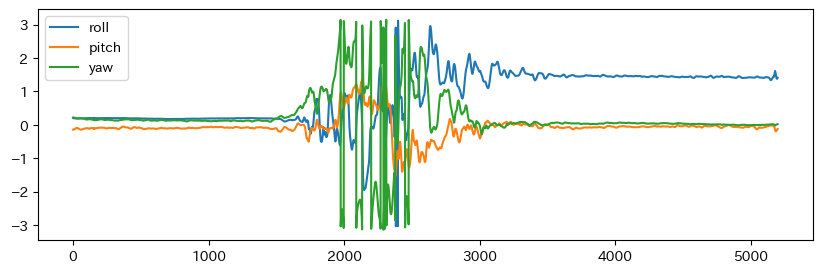

In [9]:
# datumをプロット
datum = np.array(datum)
plt.plot(datum[:, 0], label='roll')
plt.plot(datum[:, 1], label='pitch')
plt.plot(datum[:, 2], label='yaw')
plt.legend()
plt.rcParams['figure.figsize'] = (10, 3)
plt.show()
